# Introduction

This file shows the functions and implementation of the torso soft tissue algorithm. It would help us to quickly read the .py codes and pick up the parameters we need to set in the GUI. This algorithm is based on traditional image segmentation techniques. All the terms could be found and have been explained well in google.

To help create the GUI, I would recommend following the flowchart in the final report if you would like to. 

# Overview

The whole process of segmenting torso soft tissue shows in this picture.
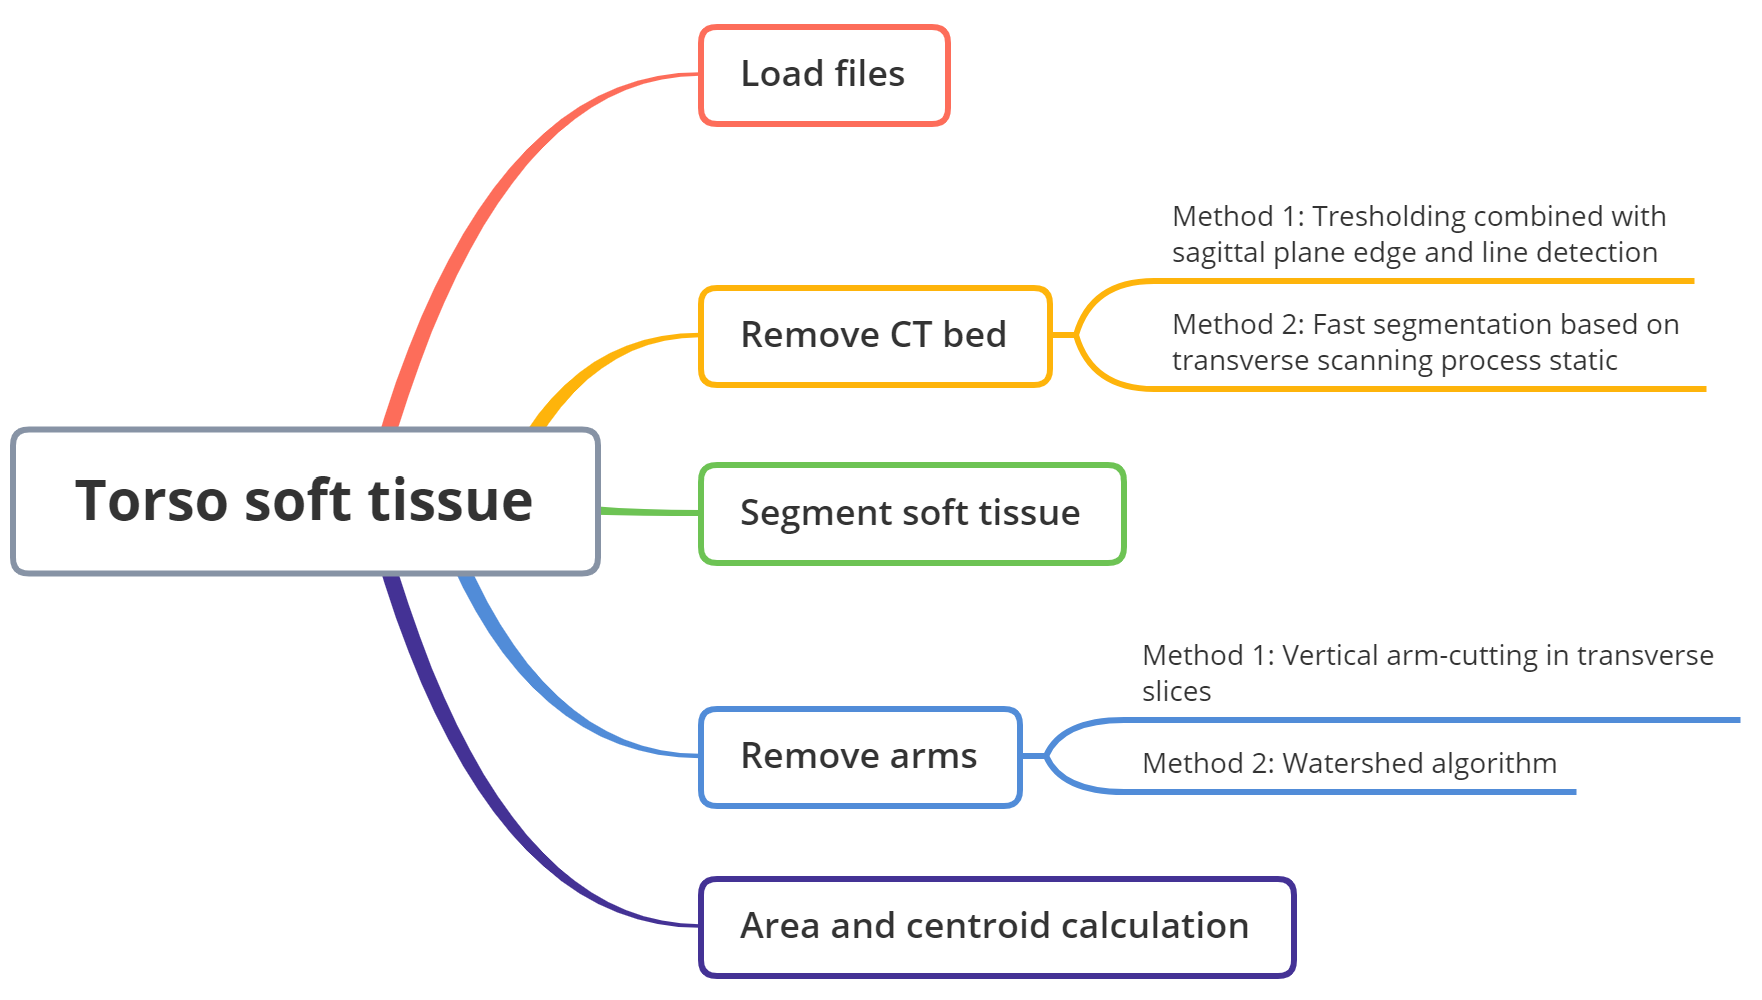

# Load files

Functions for loading all the files

In [ ]:
def FindAllTargetSlices(dir,SliceNumber):
    # Function: Find the target slices
    # Parameters:
    # dir: the CT dicom file pathway of one database
    # SliceNumber: the target slice number of the database(should overlap with the end of the file name)
    # Returns:
    # results: The file names of all target slices
    
    results = []
    folders = [dir]
    
    for i in range(len(SliceNumber)):
        specify_str = SliceNumber[i]
        for folder in folders :
            folders += [os.path.join(folder, x) for x in os.listdir(folder) \
                        if os.path.isdir(os.path.join(folder, x))]
            results += [os.path.relpath(os.path.join(folder, x), start = dir) \
                        for x in os.listdir(folder) \
                        if os.path.isfile(os.path.join(folder, x)) and specify_str in x]
                
    return results

One example of loading the database 606

In [ ]:
dir_606 = r'..\CT Scans\00606M_10_18_12\Dicom'
VertebraName_606 = ['C2','C3','C4','C5','C6','C7',
                    'T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12',
                    'L1','L2','L3','L4','L5']
SliceNumber_606 = ['1262','1227','1198','1167','1139','1112','1084','1053','1022','0989',
               '0956','0916','0879','0841','0801','0761','0716','0669','0621','0568',
               '0512','0462','0404']
Filename_606 = FindAllTargetSlices(dir_606,SliceNumber_606)
Vertebra_Filename_606 = zip(VertebraName_606,Filename_606)
Vertebra_Filename_606_list = list(Vertebra_Filename_606) 

Functions for loading the target slices

In [11]:
def FindOriginalDataByVertebraName(VertebraName,Vertebra_Filename_list,dir):
    # Function: Find the original image by vertebra name
    # Parameters:
    # VertebraName: for example C2 T4 L3...
    # Vertebra_Filename_list: the list got before when loading all the target files
    # dir: the CT dicom file pathway of one database
    # Returns:
    # ds: contains some image information
    # data: pixel array of the image
    
    for i in range(len(Vertebra_Filename_list)):
        if Vertebra_Filename_list[i][0] == VertebraName:
            file_name = Vertebra_Filename_list[i][1]
        else: i += 1
        
    file_path = os.path.join(dir,file_name)
    ds = pydicom.dcmread(file_path)
    data = ds.pixel_array 
     
    return ds, data


def GrayscaleToHU(ds,data):
    # Function: image from grayscale to hounsfield unit
    # Parameters:
    # ds: contains some image information
    # data: pixel array of the image
    # Returns:
    # data_HU: image after grayscale to hounsfield 
    
    # Rescale Intercept
    RescaleIntercept = ds[0X0028, 0X1052].value
    # Rescale Slope
    RescaleSlope = ds[0X0028, 0X1053].value
    # HU = pixel * slope + intercept
    data_HU = data * RescaleSlope + RescaleIntercept
    
    return data_HU


def SetContrastInCT(data_HU,HU_min,HU_max):
    # Function: contrast stretching in CT
    # Parameters:
    # data_HU: image after grayscale to hounsfield unit
    # Bone contrast: 250 HU to 1000 HU
    # Soft tissue contrast: -150 HU to 350 HU
    # Returns:
    # data_Contrast: image array after contrast stretching
    
    slope = 255 / (HU_max - HU_min)
    intercept = -slope * HU_min
    
    data_Contrast = np.round(slope * data_HU + intercept)
    data_Contrast[data_Contrast < 0] = 0
    data_Contrast[data_Contrast > 255] = 255
    
    return data_Contrast


def LoadImageData_HU_SoftTissue(VertebraName,Vertebra_Filename_list,dir):
    # Function: Load the image after contrast stretching to a soft tissue range(-150~350HU)
    # Parameters:
    # VertebraName: for example C2 T4 L3...
    # Vertebra_Filename_list: the list got before when loading all the target files
    # dir: the CT dicom file pathway of one database
    # Returns:
    # data_HU_SoftTissue: The image array after soft tissue contrast stretching
    
    ds,data = FindOriginalDataByVertebraName(VertebraName,Vertebra_Filename_list,dir)
    data_HU = GrayscaleToHU(ds, data)
    SoftTissueHU_min = -150
    SoftTissueHU_max = 350
    data_HU_SoftTissue = SetContrastInCT(data_HU,SoftTissueHU_min,SoftTissueHU_max)
    
    return data_HU_SoftTissue


One example of loading one target slice

In [ ]:
VertebraName = 'L3'
data_HU_SoftTissue = LoadImageData_HU_SoftTissue(VertebraName,Vertebra_Filename_606_list,dir_606)
plt.imshow(data_HU_SoftTissue, cmap='gray')
plt.title('Original image of T8(606)')
plt.show()

# Remove CT bed - method 1

Reformat to a sagittal plane image

In [7]:
def LoadAllDicomSlicesFromOneFolder(filepath):    
    # Function: Load all the dicom files from the database dicom folder
    # Parameters:
    # filepath: the pathway containing the database dicom file
    # Returns:
    # results: all the dicom file names
    
    files = []
    print(len(os.listdir(filepath)))
    for file in os.listdir(filepath):
        child = os.path.join(filepath, file)
        files.append(pydicom.dcmread(child))
    return files

In [ ]:
files = LoadAllDicomSlicesFromOneFolder(dir)
print("file count: {}".format(len(files)))         

slices = []

for f in files:
    slices.append(f)

ri = slices[0].RescaleIntercept
rs = slices[0].RescaleSlope

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

Create the CT bed profile

In [9]:
def CTTableTopInterceptFinding(SagittalImage_HU):
    # Function: Find the CT bed top intercept
    # Parameters:
    # SagittalImage_HU: Sagittal images after contrast stretching(-150~350HU) 
    # Returns:
    # results: The CT bed top intercept(points in one array)
    
    SagittalImage_HU_Binary = SagittalImage_HU > -500
    SagittalImage_HU_Binary = SagittalImage_HU_Binary.astype(np.uint8)
    plt.imshow(SagittalImage_HU_Binary,cmap='gray')
    plt.show()

    # Edge detection using Sobel
    x = cv.Sobel(SagittalImage_HU_Binary,cv.CV_16S,1,0)
    y = cv.Sobel(SagittalImage_HU_Binary,cv.CV_16S,0,1)
    absX = cv.convertScaleAbs(x)   
    absY = cv.convertScaleAbs(y)

    # Detect vertical edges by Hough transform with angle and intercept
    SagittalImage_Edges = cv.addWeighted(absX,0,absY,1,0)
    SagittalImage_Lines = cv.HoughLines(SagittalImage_Edges,1,np.pi/180,400) #400 can be changed here, you can try 300,400,500,600

    # Choose the angle that gives the largest bin count
    rho_CTbed = []
    for i in range(0,len(SagittalImage_Lines)):
        rho,theta = SagittalImage_Lines[i][0][0],SagittalImage_Lines[i][0][1]
        TolerentRad = 0.1 * np.pi/180
        if theta < 90 * np.pi/180 + TolerentRad and theta > 90 * np.pi/180 - TolerentRad:
            rho_CTbed.append(rho)
    rho_CTbed = np.sort(rho_CTbed)
    print(rho_CTbed)

    # Pick the corresponding intercept as table top
    TableTop_initial = []
    for i in range(len(rho_CTbed)):
        if rho_CTbed[i] > 0.5*SagittalImage_HU.shape[0]:
            TableTop_initial.append(rho_CTbed[i])   
    TableTop_CTbed = int(min(TableTop_initial))
    
    return TableTop_CTbed

In [ ]:
TableTop_CTbed = np.ones(int(img_shape[1])) * int(img_shape[0])
for i in range(40,int(img_shape[1]-1)-40): # 40 can be changed here, you can try 20,30,40       
    SagittalImage = img3d[:, i, :]
    SagittalImage_HU = SagittalImage * rs + ri
    TableTop_CTbed[i] = CTTableTopInterceptFinding(SagittalImage_HU)

Remove the CT bed 

In [ ]:
data_CTBedRemoval = data_HU_SoftTissue
for i in range(len(TableTop_CTbed)):
    data_CTBedRemoval[int(TableTop_CTbed[i]):data_HU_SoftTissue.shape[0],i] = 0
plt.imshow(data_CTBedRemoval)

# Remove CT bed - method 2

Load the slice for CT bed projection detection

In [ ]:
VertebraName_BED = 'C2'
data_HU_BED_SoftTissue = LoadImageData_HU_SoftTissue(VertebraName_BED,Vertebra_Filename_606_list,dir_606)
plt.imshow(data_HU_BED_SoftTissue, cmap='gray') 
plt.title('Original image of C2(606)')
plt.show()

Load the target slice

In [ ]:
VertebraName = 'L3'
data_HU_SoftTissue = LoadImageData_HU_SoftTissue(VertebraName,Vertebra_Filename_606_list,dir_606)
plt.imshow(data_HU_SoftTissue, cmap='gray')
plt.title('Original image of T8(606)')
plt.show()

Extract the CT bed projection

Function "InitialTorsoSeg" will be mentioned later.

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)) # could be changed, usually (1,1) or (2,2)
Torso_initial_mask_BED,MaxConnectedArea_BED = InitialTorsoSeg(data_HU_BED_SoftTissue,kernel)

TorsoRegionIndex_BED = np.where(Torso_initial_mask_BED == True)
CTBedRegion = data_HU_BED_SoftTissue
CTBedRegion[TorsoRegionIndex_BED] = 0
CTBedRegion_mask = CTBedRegion > 0

Remove CT bed

In [ ]:
CTBedRegionIndex = np.where(CTBedRegion_mask == True)
data_CTBedRemoval = data_HU_SoftTissue
data_CTBedRemoval[CTBedRegionIndex] = 0

# Segment soft tissue

Soft tissue = Initial torso - Body cavity

In [ ]:
def InitialTorsoSeg(data_HU_SoftTissue,kernel):
    # Function: Initial Torso Region Segmentation
    # Parameters:
    # data_HU_SoftTissue:data need to be segmented
    # kernel:close operation kernel
    # Results:
    # Torso_initial_mask: the intial torso mask (torso + arms)
    # MaxConnectedArea: the mask before filling all the holes
    
    ret,mask = cv.threshold(data_HU_SoftTissue,0,255,cv.THRESH_BINARY) 
    morph_close = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel) # close operation to remove small spots
    labels, num=measure.label(morph_close,connectivity=2,background=0,return_num=True) # label connected areas
    
    NumberofEachArea = []
    for i in range(num+1):
        NumberofEachArea.append(np.sum(labels == i))
        
    tmp_list=sorted(NumberofEachArea) # sort the labels
    final = tmp_list[-2] # The most pixels are in the background, so choose the second largest label after sorting
    idx = NumberofEachArea.index(final) # label we want
    MaxConnectedArea = np.where(labels == idx, 1, 0) # keep all the pixels that label=idx
    Torso_initial_mask = scipy.ndimage.binary_fill_holes(MaxConnectedArea)
    
    return  Torso_initial_mask,MaxConnectedArea


def BodyCavitySeg(Torso_initial_mask,MaxConnectedArea,min_size):
    # Function: Body cavity segmentation
    # Parameters:
    # Torso_initial_mask: from InitialTorsoSeg
    # MaxConnectedArea: from InitialTorsoSeg
    # min_size: The smallest tolerated area of the body cavity
    # Results:
    # BodyCavity_mask: the body cavity mask
    
    BodyCavity_initial = Torso_initial_mask - MaxConnectedArea
    label_BodyCavity = measure.label(BodyCavity_initial) # Zoning of areas of initial soft tissue, 8 contiguous
    BodyCavity_mask = morphology.remove_small_objects(label_BodyCavity, min_size, connectivity=2) # remove small objects with the min_size
    BodyCavity_mask = BodyCavity_mask > 0 # label has values, so the returned mask needs to be binarized, leaving only 0, 1
    
    return BodyCavity_mask

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))# could be changed,usually the same as the previous kernel in CT bed removal method 2
Torso_initial_mask,MaxConnectedArea = InitialTorsoSeg(data_CTBedRemoval,kernel)
min_size = 15 # could be changed, don't set this too high
BodyCavity_initial_mask = BodyCavitySeg(Torso_initial_mask,MaxConnectedArea,min_size)

# Remove arms - method 1

Functions for arm removal 

In [ ]:
def ArmRemovalBySearchingConcavePoints(Torso_initial_mask,height,distance):
    # Function: Vertical arm-cutting from the junctions between arm and torso
    # Parameters:
    # Torso_initial_mask: from InitialTorsoSeg
    # distance: a approximate number of points between left and right arms, usually 200
    # height: usually 100, set based on the Torso_initial_mask_sum_neg
    # Results:
    # Torso_mask: contains only the torso part
    
    # Sum all the rows of Torso_initial_mask threshold the profile
    Torso_initial_mask_sum_rows = np.sum(Torso_initial_mask, axis=0)

    # negative uint32 is a bit strange, so there convert uint32 to float64
    Torso_initial_mask_sum_rows = np.array(list(map(np.float,Torso_initial_mask_sum_rows)))
    Torso_initial_mask_sum_neg = -Torso_initial_mask_sum_rows + np.max(Torso_initial_mask_sum_rows)
    plt.plot(Torso_initial_mask_sum_neg)

    # find peak locations -- find concave points
    peak_locx,peak_property = find_peaks(Torso_initial_mask_sum_neg, height=100, distance=200)
    peak_height = peak_property['peak_heights']
    print('peak_locx',peak_locx)
    print('peak_height',peak_height) 

    NumofConcavePoints = len(peak_locx) 
    
    Torso_mask = Torso_initial_mask   
    
    if NumofConcavePoints == 0:
        Torso_mask = Torso_initial_mask
    elif NumofConcavePoints == 1 and peak_locx[0] < 0.5 * Torso_initial_mask.shape[1]: # Left Arm
        Arm_LeftConcave = peak_locx[0]
        Torso_mask[:,0:Arm_LeftConcave] = 0
    elif NumofConcavePoints == 1 and peak_locx[0] > 0.5 * Torso_initial_mask.shape[1]: # Right Arm
        Arm_RightConcave = peak_locx[0]
        Torso_mask[:,Arm_RightConcave:Torso_mask.shape[1]] = 0
    elif  NumofConcavePoints == 2: # Left & Right Arms
        Arm_LeftConcave = peak_locx[0]
        Arm_RightConcave = peak_locx[1]
        Torso_mask[:,0:Arm_LeftConcave] = 0
        Torso_mask[:,Arm_RightConcave:Torso_mask.shape[1]] = 0
    else:
        Torso_mask = Torso_initial_mask
        
    return Torso_mask

In [ ]:
Torso_mask = ArmRemovalBySearchingConcavePoints(Torso_initial_mask,height=100,distance=200)
# Plot the Torso_initial_mask_sum_neg profile to decide the height and distance.
# Height and distance could be changed based on different slices.
# For some slices, we need to run this code for several times. 
# Therefore, I would recommend adding one button to repeat this process.

# Remove arms - method 2

Functions for arm removal

In [ ]:
def BoneContrastRemoval(data_HU,data_HU_SoftTissue,BoneHUReset):
    # Function: Remove bone contrast of the soft tissue image
    # Parameters:
    # data_HU:the data after GraytoHU
    # data_HU_SoftTissue: the data with soft tissue HU range
    # BoneHUReset: the HU the bone region needs to be, typical value 90, range from 80 to 120
    # Returns:
    # data_HU_SoftTissue_Boneremove: the soft tissue image after bone contrast removal

    # Bone HU range from ScienceDirect
    BoneHU_min = 150 # ADJUST A BIT FROM 250 TO 150
    BoneHU_max = 1000
    data_HU_Bone = SetContrastInCT(data_HU,BoneHU_min,BoneHU_max) 

    data_HU_SoftTissue_Boneremove = data_HU_SoftTissue
    data_HU_SoftTissue_Boneremove[np.where(data_HU_Bone > 0)] = BoneHUReset 
    
    return data_HU_SoftTissue_Boneremove


def ArmRemovalByManualWatershed(Torso_initial_mask,data_HU_SoftTissue_Boneremove,fg,k_fg):
    # Function: remove arms by watershed algorithm(need manually seed point setting)
    # Parameters:
    # Torso_initial_mask: from InitialTorsoSeg
    # data_HU_SoftTissue_Boneremove: the soft tissue image after bone contrast removal
    # fg: manual seed points
    # k_fg: manual seed point shape and size setting
    # Returns:
    # NumofSeedPoints: refers to the number of arms
    # Arms_mask_watershed: arm mask got from watershed (Arm mask will be used.)
    # Torso_mask_watershed: torso mask got from watershed (Not be used.)
    
    sure_fg = cv.dilate(fg,k_fg,iterations = 1)
    sure_fg = np.uint8(sure_fg)
    ret, markers = cv.connectedComponents(sure_fg)
    # bg setting
    sure_bg = Torso_initial_mask
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    sure_fg = np.uint8(sure_fg)
    sure_bg = np.uint8(sure_bg)
    unknown = cv.subtract(sure_bg,sure_fg)
    markers[unknown == 1] = 0

    data_watershed = data_HU_SoftTissue_Boneremove
    data_watershed = np.uint8(data_watershed)
    data_watershed = cv.cvtColor(data_watershed,cv.COLOR_GRAY2RGB)

    markers = cv.watershed(data_watershed,markers)
    
    data_watershed[markers == -1] = [0,0,255]
    
    NumofSeedPoints = np.sum(fg == 1)
    print(NumofSeedPoints)
    
    if NumofSeedPoints == 2:
        NumberofEachArea = [] 
        for i in range(markers.max()+1):
            NumberofEachArea.append(np.sum(markers == i))       
        tmp_list=sorted(NumberofEachArea)
        print(tmp_list)
        Arm_Num = tmp_list[1] # 1:Arm;2:Torso;3:Background
        Torso_Num = tmp_list[2]
        Arm_idx = NumberofEachArea.index(Arm_Num)
        Torso_idx = NumberofEachArea.index(Torso_Num)
        Arms_mask_watershed = np.where(markers == Arm_idx, 1, 0)
        Torso_mask_watershed = np.where(markers == Torso_idx, 1, 0)
    
    elif NumofSeedPoints == 3: 
        NumberofEachArea = [] 
        for i in range(markers.max()+1):
            NumberofEachArea.append(np.sum(markers == i))       
        tmp_list=sorted(NumberofEachArea)
        print(tmp_list)
        Arm1_Num = tmp_list[1] # 1&2:Arms;3:Torso;4:Background
        Arm2_Num = tmp_list[2] 
        Torso_Num = tmp_list[3]
        Arm1_idx = NumberofEachArea.index(Arm1_Num)
        Arm2_idx = NumberofEachArea.index(Arm2_Num)
        Torso_idx = NumberofEachArea.index(Torso_Num)
        Arms_mask_watershed = np.where(markers == Arm1_idx, 1, 0)+np.where(markers == Arm2_idx, 1, 0)
        Torso_mask_watershed = np.where(markers == Torso_idx, 1, 0)
    
    return NumofSeedPoints,Arms_mask_watershed,Torso_mask_watershed

Manual seed point setting and watershed algorithm:

I would recommend creating a tool that can let the user select the seed points in target slices directly rather than give the pixel number to 'fg'.

Better segmentation happens when the seed points are closer to the junction between arm and torso.

For seperating two arms, we can try either set 3 seed points(left arm, torso, right arm) or set 2 seed points(1 arm and torso) and run twice. 

In [ ]:
# Manual seed point setting:
fg = np.zeros(Torso_initial_mask.shape,dtype='uint8')
fg[275,70] = 1 # left arm
fg[270,250]= 1 # torso
fg[290,410] = 1 # right arm
k_fg = cv.getStructuringElement(cv.MORPH_ELLIPSE,(45,45))

data_HU_SoftTissue_Boneremove = BoneContrastRemoval(data_HU,data_HU_SoftTissue,BoneHUReset=90)
NumofSeedPoints,Arms_mask_watershed,Torso_mask_watershed = ArmRemovalByManualWatershed(Torso_initial_mask,data_HU_SoftTissue_Boneremove,fg,k_fg)

if NumofSeedPoints == 0: # So here we don't need the seed points for those slices without arms
    Torso_mask_InitialMinusArms = Torso_initial_mask
else: 
    Arms_mask_watershed = Arms_mask_watershed.astype(np.uint8)
    Arms_mask_watershed_dilation = cv.dilate(Arms_mask_watershed,kernel,iterations = 3)
    Torso_mask_InitialMinusArms = Torso_initial_mask
    Torso_mask_InitialMinusArms[np.where(Arms_mask_watershed_dilation == True)] = False

    labels, num=measure.label(Torso_initial_mask,connectivity=2,background=0,return_num=True)
    NumberofEachArea = []
    for i in range(num):
        NumberofEachArea.append(np.sum(labels == i))       
    tmp_list=sorted(NumberofEachArea)
    final = tmp_list[-2] 
    idx = NumberofEachArea.index(final) 
    Torso_initial_mask = np.where(labels == idx, 1, 0) 
    Torso_mask_InitialMinusArms = Torso_initial_mask

plt.imshow(Torso_mask_InitialMinusArms, cmap='gray')
plt.title('Torso_mask_InitialMinusArms')
plt.show()

# Area and centroid calculation

Functions for parameter calculation

In [ ]:
def AllAreaPerimeterCentroid(contours):  
    # Function: calcualte the area, perimeter, x-centroid, y-centroid of any mask
    # Parameters:
    # contours: mask contours
    # Returns:
    # area,perimeter,cx,cy: area, perimeter, x-centroid, y-centroid of the mask
    
    area = np.zeros(len(contours))
    perimeter = 0
    cx = np.zeros(len(contours))
    cy = np.zeros(len(contours))
    
    for i in range(len(contours)):
        perimeter += cv.arcLength(contours[i],True)
        area[i] = cv.contourArea(contours[i])
        M = cv.moments(contours[i])
        cx[i] = int(M['m10']/M['m00'])
        cy[i] = int(M['m01']/M['m00'])

    return area,perimeter,cx,cy


def SoftTissueParameter(contours_Torso,contours_BodyCavity):
    # Function: geometric decomposition
    # Parameters:
    # contours_Torso: torso contours
    # contours_BodyCavity: body cavity contours
    # Returns:
    # Area_SoftTissue: torso soft tissue area
    # Perimeter_SoftTissue: torso soft tissue perimeter
    # cx_SoftTissue,cy_SoftTissue: torso soft tissue centroid
    
    # calculate parameters of torso
    Area_Torso, Perimeter_Torso,cx_Torso,cy_Torso = AllAreaPerimeterCentroid(contours_Torso)
    
    # calculate parameters of body cavity
    Area_BodyCavity, Perimeter_BodyCavity,cx_BodyCavity,cy_BodyCavity = AllAreaPerimeterCentroid(contours_BodyCavity)
   
    # calculate parameters of soft tissue
    Area_SoftTissue = np.sum(Area_Torso) - np.sum(Area_BodyCavity)
    Perimeter_SoftTissue = np.sum(Perimeter_Torso) + np.sum(Perimeter_BodyCavity)
    cx_SoftTissue =  (cx_Torso * Area_Torso - np.sum(cx_BodyCavity * Area_BodyCavity)) / Area_SoftTissue  
    cy_SoftTissue =  (cy_Torso * Area_Torso - np.sum(cy_BodyCavity * Area_BodyCavity)) / Area_SoftTissue                        

    return Area_SoftTissue,Perimeter_SoftTissue,cx_SoftTissue,cy_SoftTissue

In [ ]:
# Soft Tissue contours  
data_HU_SoftTissue_Color = cv.cvtColor(data_HU_SoftTissue.astype(np.uint8), cv.COLOR_GRAY2RGB)
# Parameter calculation
Area_SoftTissue,Perimeter_SoftTissue,cx_SoftTissue,cy_SoftTissue = SoftTissueParameter(contours_Torso_InitialMinusArms, contours_BodyCavity)

PixelSize = 0.976562  # mm
Area_SoftTissue_mm = np.sum(SoftTissue_mask) * PixelSize * PixelSize # mm^2
print('Area_SoftTissue_mm ',Area_SoftTissue_mm)

Other code in .py is related to evaluation or result display and can be used when displaying intermediate or final results. I recommend rewriting the results display code when needed rather than copying it from the original code.

That's all. Hope this file helps!